In [1]:
import os
import numpy as np
import pandas as pd
from scipy.io import loadmat
import json
import matplotlib.pylab as plt
import numpy as np
from joblib import Parallel, delayed

Load the combat data

In [3]:
data_after_combat = np.load('../data/data_after_combat.npz')
demo_cluster = pd.read_excel("../data/pheno_w_clusters.xlsx")

In [4]:
CC_adjust = data_after_combat['CC_adjust']
subjects = data_after_combat['subjects']
age = data_after_combat['age']
sex = data_after_combat['sex']
group = data_after_combat['group']

In [5]:
CC_adjust.shape

(1890, 86, 86)

Load computed cluster

In [6]:
n_rois = CC_adjust.shape[1]

In [7]:
def gower(D): 
    # Convert distance object to matrix form
    #D = as.matrix(D)

    # Dimensionality of distance matrix
    n = int(D.shape[0])

    # Create Gower's symmetry matrix (Gower, 1966)
    A = -0.5*np.square(D)

    # Subtract column means As = (I - 1/n * 11")A
    As = A - np.outer(np.ones(n),  A.mean(0))
    #Substract row
    G = As - np.outer(As.mean(1), np.ones(n))

    return G

def hat_matrix(X):
    """
    Calculates distance-based hat matrix for an NxM matrix of M predictors from
    N variables. Adds the intercept term for you.
    """
    n = X.shape[0]
    
    
    X = np.column_stack((np.ones(n), X)) # add intercept
    
    XXT = np.matmul(X.T, X)
    XXT_inv = np.linalg.inv(XXT)
    
    H = np.matmul(np.matmul(X, XXT_inv), X.T)

    return H

def compute_SSB(H, G, df1):
    trace_HG = np.trace(np.matmul(H, G))
    return trace_HG/df1
    
def compute_SSW(H, G, df2):
    trace_HG = np.trace(np.matmul(H, G))
    trace_G  = np.trace(G)

    return (trace_G - trace_HG )/df2

def design_matrices(df):
    
    X_list = []
    for ii in  range(df.shape[1]):
        #TODO: category gives error
        if (df.iloc[:, ii].dtype=='object'):
            X_list.append(pd.get_dummies(df.iloc[:, ii], 
                                         drop_first=True).values)
        else:
            X_list.append(df.iloc[:, ii].values[:, np.newaxis])
            
    return X_list

def mdmr(X, D, n_perm=100):
    H = hat_matrix(X)
    
    #omnibus effect 
    
    # Computational trick: H is idempotent, so H = HH. tr(ABC) = tr(CAB), so
    # tr(HGH) = tr(HHG) = tr(HG). Also, tr(AB) = vec(A)"vec(B), so
    trHG = np.matmul(H.flatten().T, G.flatten())

    # Numerical trick: tr((I-H)G(I-H)) = tr(G) - tr(HGH), so
    trG  = np.trace(G)
    
    F = trHG/(trG - trHG )

class MDMR(object):
    
    def __init__(self, n_perms = 100, random_state=None, n_jobs = None):
        self.n_perms = n_perms
        self.random_state = random_state
        self.n_jobs = n_jobs
        
    def fit(self, X_df, D, G=None):
         
        #TODO: Check D symmetrical and convert to numpy
        
        # Compute Gower matrix and its trace for later
        if G is None:
            G = gower(D)
        trG = np.trace(G)
        
        # Check input is a dataframe
        if isinstance(X_df, pd.DataFrame) is False:
            raise AttributeError("Input data must be a dataframe")

        # Extract list of design matrices from the dataframe. This is done
        # to be able to handle categorical features
        X_list = design_matrices(X_df)
    
        # Full model hat matrix
        X_full = np.column_stack(X_list)
        
        # N observations and m features (without intercept)
        N, m = X_full.shape
        
        H_full = hat_matrix(X_full)
        df2 = N - m
        
        den = compute_SSW(H_full, G, df2) 
        
        # Compute SSB for full model (omnibus)
        num_omni = compute_SSB(H_full, G, m)
        
        # Compute F and R2 for omnibus model
        self.F_omni_ = num_omni/den
        self.r2_omni_ = num_omni*m/trG

        # Compute differences between H and defreees of freedom
        H_list = []
        for ii in range(len(X_list)):
            temp = X_list.copy()
            temp.pop(ii)
            if temp:
                H_ii = H_full - hat_matrix(np.column_stack(temp))
            else:
                H_ii = H_full 
            H_list.append(H_ii)
            
        # Compute degrees of freedom
        df1_list = []
        for X in X_list:
            m_ii = X.shape[1]
            df1_list.append(m_ii)
        
        # Compute SSB for each column
        num_x = Parallel(n_jobs=self.n_jobs)(delayed(compute_SSB)(H, G, df1) for \
                                           (H, df1) in zip(H_list, df1_list))            
        num_x = np.array(num_x)
            
        self.F_ = num_x/den
        # pseudo R2.Note that we have to multiply by the degrees of freedom
        self.r2_ = np.multiply(num_x, np.array(df1_list))/trG

       

In [8]:
from scipy.spatial.distance import pdist, squareform

First, compute stats

In [9]:
vars_interest = ['DX_GROUP', 'AGE_AT_SCAN', 'SEX',  'FIQ', 'VIQ', 'PIQ']

In [10]:
to_take = ~np.any(demo_cluster.loc[:, vars_interest].isna(), axis=1).values

In [11]:
X_df = demo_cluster.loc[to_take, vars_interest]
YY = CC_adjust[to_take, :, :]

In [12]:
X_df['DX_GROUP'] = X_df['DX_GROUP'].astype(str)
X_df['SEX'] = X_df['SEX'].astype(str)

In [13]:
X_df.head()

,DX_GROUP,AGE_AT_SCAN,SEX,FIQ,VIQ,PIQ
0,2,44.2,1,104.0,113.0,94.0
1,2,39.3,1,123.0,127.0,112.0
2,2,42.5,1,97.0,85.0,109.0
3,2,19.7,1,116.0,117.0,116.0
4,2,20.0,2,111.0,110.0,109.0


In [15]:
from mdmr import MDMR
from scipy.spatial.distance import squareform, pdist

ModuleNotFoundError: No module named 'mdmr'

In [57]:
# save
pd.DataFrame({"F_tdc_asd":np.array(list_Fs)}).to_csv("../data/F_tdc_asd.csv", index=False)

In [63]:
[np.corrcoef(pd.read_csv("../data/mdmr_clusters_healthy_stats.csv").iloc[:, ii].values, 
             np.array(list_Fs))[0,1] for ii in range(1, 4)]

[0.4580804278064599, 0.7587678867393802, 0.40477849395603344]

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns

In [28]:
from scipy.stats import spearmanr, pearsonr

In [32]:
vars_interest = ['clus_id', 'AGE_AT_SCAN', 'SEX',  'FIQ', 'VIQ', 'PIQ']

In [33]:
to_take = ~np.any(demo_cluster.loc[:, vars_interest].isna(), axis=1).values

In [34]:
X_df = demo_cluster.loc[to_take, vars_interest]
YY = CC_adjust[to_take, :, :]

In [36]:
X_df['clus_id'] = X_df['clus_id'].astype(str)
X_df['SEX'] = X_df['SEX'].astype(str)

In [57]:
res_F_df = pd.DataFrame({})
res_r2_df = pd.DataFrame({})

for jj in np.arange(1, 4):
    list_Fs = []
    list_rs = []
    list_pv = []
    cond = (X_df.clus_id=='0') | (X_df.clus_id==str(jj))
    
    XX = X_df.loc[cond,:]
    
    for ii in range(YY.shape[1]):

            D = squareform(np.sqrt(2*pdist(YY[cond, ii, :], 'correlation')))
            mdmr = MDMR(n_perms=None)
            mdmr.fit(XX, D)
            list_Fs.append(mdmr.F_[0])
            list_rs.append(mdmr.r2_[0])
            
    res_F_df['clus_' + str(jj)] = list_Fs
    res_r2_df['clus_' + str(jj)] = list_rs

In [ ]:
res_F_df.to_csv('../data/mdmr_clusters_healthy_stats.csv')

plot of stats

In [52]:
import seaborn as sns
current_palette=sns.color_palette('colorblind')
colors = [current_palette[4], current_palette[1], current_palette[2]]

/home/javi/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/javi/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/home/javi/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/javi/anaconda3

Text(0.5, 0, 'pseudo R-square')

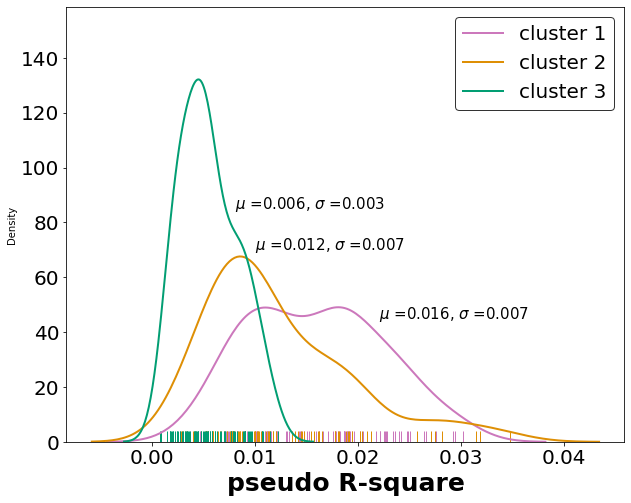

In [58]:
text_pos = [[0.022, 45],
            [0.01, 70],
            [0.008, 85]
            ]

fig, ax = plt.subplots(figsize=(10, 8))
for ii in range(3):
    
    #mu, sd = res_F_df.iloc[:,ii].mean(), res_F_df.iloc[:,ii].std()
    mu, sd = res_r2_df.iloc[:,ii].mean(), res_r2_df.iloc[:,ii].std()
    sns.distplot(res_r2_df.iloc[:,ii], 
                 hist = False, 
                 rug=True,
                 norm_hist=False, color=colors[ii], 
                 label="cluster %d" % (ii+1), 
                 kde_kws={"lw": 2})
    
    pos = text_pos[ii]
    ax.text(x=pos[0], y=pos[1], s = r'$\mu$ =%.3f, $\sigma$ =%.3f' % (mu, sd), size=15)
#    ax.vlines(x=mu, ymin=-0.5, ymax=120)
    
ax.legend(prop={'size':20}, edgecolor = 'black')
ax.tick_params(labelsize=20)
ax.set_xlabel("pseudo R-square", size=25, weight='bold')
#plt.savefig("../plots/panel_d_fs.svg", dpi=600)
#plt.savefig("../plots/panel_d_fs.png", dpi=600)

/home/javi/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/javi/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/home/javi/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/javi/anaconda3

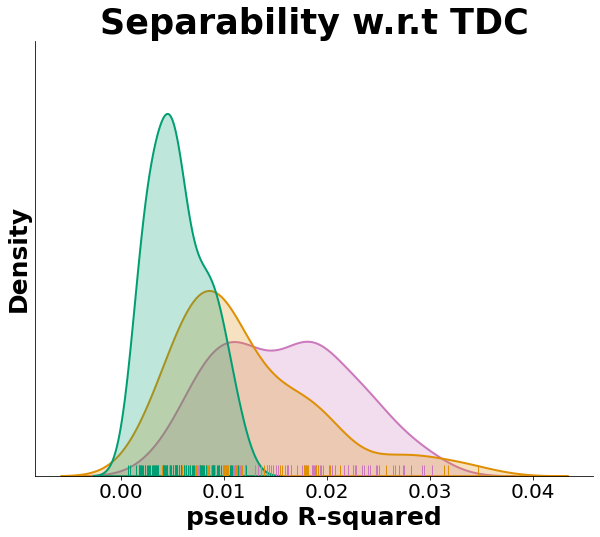

In [59]:
text_pos = [[0.022, 45],
            [0.01, 70],
            [0.006, 125]
            ]

fig, ax = plt.subplots(figsize=(10, 8))
for ii in range(3):
    
    mu, sd = res_r2_df.iloc[:,ii].mean(), res_r2_df.iloc[:,ii].std()
    sns.distplot(res_r2_df.iloc[:,ii], 
                 hist = False,
                 kde=True,
                 rug=True, 
                 norm_hist=False, 
                 color=colors[ii],
                 kde_kws={"lw": 2, 'shade':True})
    
    #pos = text_pos[ii]
    #ax.text(x=pos[0], y=pos[1], s = r'$\mu$ =%.3f, $\sigma$ =%.3f' % (mu, sd), size=15)
    #ax.vlines(x=mu, ymin=-0.5, ymax=120)

#ax.vlines(x=0, ymin=-0.5, ymax=120)
ax.tick_params(labelsize=20)
ax.set_xlabel("pseudo R-squared", size=25, weight='bold')
ax.set_ylabel("Density", size=25, weight='bold')
ax.set_title("Separability w.r.t TDC", size=35, weight='bold')
ax.set_yticks([])
sns.despine()
plt.savefig("../plots/fig_2_panel_e.svg", dpi=600)
plt.savefig("../plots/fig_2_panel_e.png", dpi=600)